**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
# IMPORTS HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Info about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

Read in the data set "Miles_Traveled.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [2]:
# CODE HERE
df = pd.read_csv('../UPDATE-TSA-NOTEBOOKS/Data/Miles_Traveled.csv', index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.rename(columns={'TRFVOLUSM227NFWA':'Miles'},inplace=True)
df.head()

,Miles
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


**Task: Change the column names to Value**

**TASK: Plot out the time series**

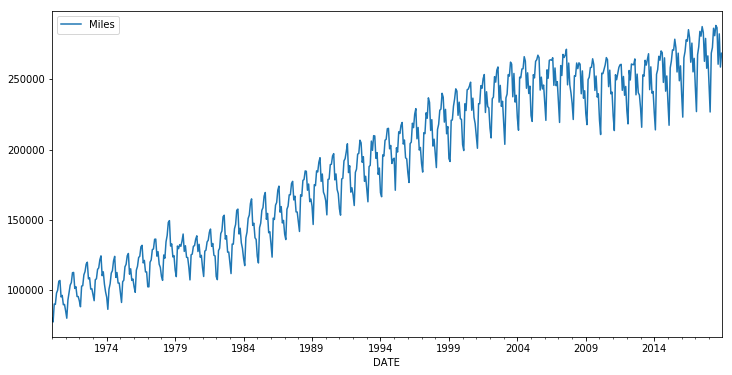

In [3]:
# CODE HERE
df.plot(figsize=(12,6));

**TASK: Perform a Seasonal Decomposition on the model and plot out the ETS components**

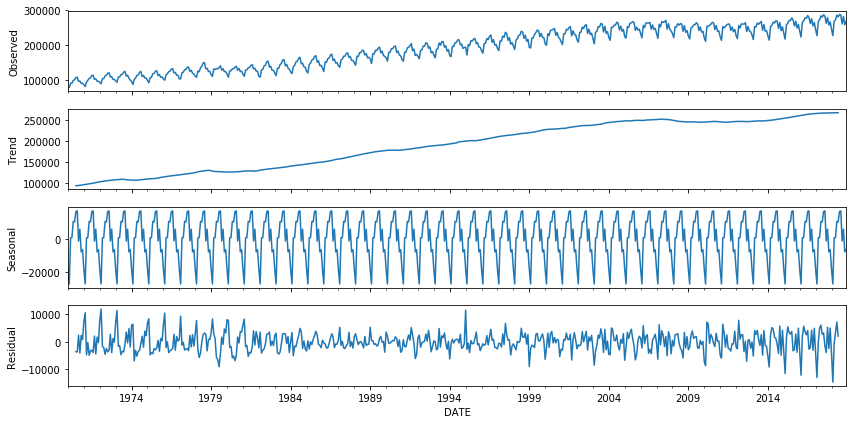

In [4]:
# CODE HERE
# model = 'additive' 'multiplicative'
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Miles'],model='add')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
result.plot();

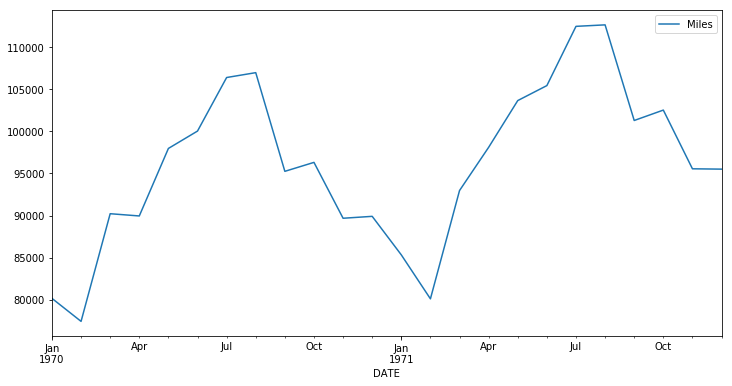

In [5]:
# Yearly Seasonality
df[:24].plot();

## Train Test Split

**TASK: Figure out the length of the data set**

In [6]:
# CODE HERE
print(len(df))
train = df.iloc[:576]
test = df.iloc[576:]

588


**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [7]:
len(test)

12

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [8]:
# CODE HERE
from sklearn.preprocessing import MinMaxScaler

# Instantiate
scaler = MinMaxScaler()

# Fit: Find the max value in the training dataset
scaler.fit(train)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# normalize the dataset
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# inverse transform
inversed_scaled_train = scaler.inverse_transform(scaled_train)
inversed_scaled_test = scaler.inverse_transform(scaled_test)

Min: 77442.000000, Max: 287343.000000


# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

In [9]:
#CODE HERE
from keras.preprocessing.sequence import TimeseriesGenerator
# len(train_generator) = len(scaled_train) - n_inputs
n_input = 24      # seasonality every 12 months MIN 12 MONTHS
n_features = 1    # How many columns you have...for TS it should be just one
# TimeSeries Generator
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

Using TensorFlow backend.


### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
# units = number of neurons, activation = activation function, input_shape, input_dim is the input dimesion
model = Sequential()
# First Layer LSTM
model.add(LSTM(units=150,input_shape=(n_input,n_features),activation='relu'))
# Output Layer
model.add(Dense(units=1))
# Compile
model.compile(loss='mse',optimizer='adam')
# Summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**TASK: Fit the model to the generator (it should be a lot of epochs, but do as many as you have the patience for! :)**

In [11]:
# CODE HERE
# Fitting our Neuronal Network
# epochs really depends on how large your dataset is...and how much training data you have....
model.fit_generator(train_generator,epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
552/552 [==============================] - 14s 26ms/step - loss: 0.0143
Epoch 2/100
552/552 [==============================] - 13s 24ms/step - loss: 0.0061
Epoch 3/100
552/552 [==============================] - 15s 27ms/step - loss: 0.0055
Epoch 4/100
552/552 [==============================] - 13s 24ms/step - loss: 0.0057
Epoch 5/100
552/552 [==============================] - 15s 26ms/step - loss: 0.0057
Epoch 6/100
552/552 [==============================] - 13s 24ms/step - loss: 0.0039
Epoch 7/100
552/552 [==============================] - 13s 24ms/step - loss: 0.0027
Epoch 8/100
552/552 [==============================] - 13s 24ms/step - loss: 0.0025
Epoch 9/100
552/552 [==============================] - 14s 26ms/step - loss: 0.0018
Epoch 10/100
552/552 [==============================] - 14s 26ms/step - loss: 0.0020
Epoch 11/100
552/552 [==============================] - 14s 25ms/step - loss: 0.0015
Epoch 12/100
552/552 [====

**TASK: Plot the history of the loss that occured during training.**

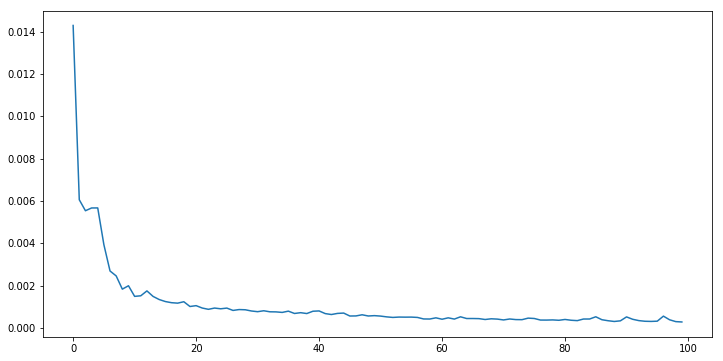

In [12]:
# CODE HERE
# Plotting loss vs epochs
loss = model.history.history['loss']
epochs = range(len(loss))
plt.plot(epochs,loss);

## Evaluate on Test Data

**TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch" like we did in the lecture.**

**TASK: Generate predictions into the same time stamps as the test set**

## Inverse Transformations and Compare

**TASK: Inverse Transform your new forecasted predictions.**

**TASK: Create a new dataframe that has both the original test values and your predictions for them.**

**TASK: Plot out the test set against your own predicted values.**

/home/eduardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


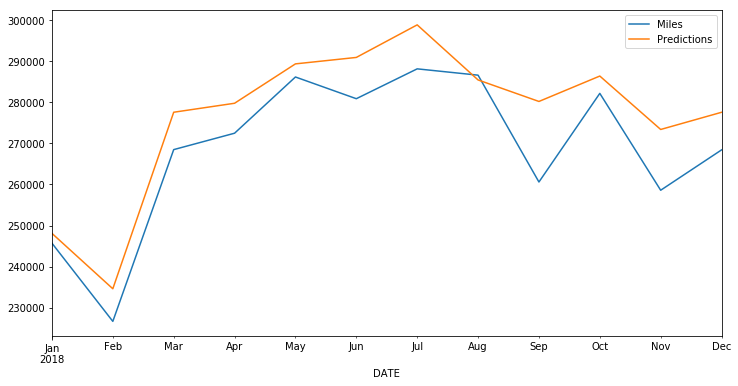

In [13]:
# CODE HERE
# holding my predictions
test_predictions = []

# last n_input points from our training dataset
first_eval_batch = scaled_train[-n_input:]
# reshape this to the right format to work with RNN (same format as TTimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse Transformation
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(12,6));

In [14]:
# CODE HERE
from statsmodels.tools.eval_measures import rmse
error = rmse(test['Miles'],test['Predictions']) # Compare it with test.mean()
error

9734.646751583465

In [15]:
test['Miles'].mean()

268739.6666666667

# Saving Models

**TASK: Optional, Save your model!**

In [16]:
model.save('mymodel.h5')